In [ ]:
# Install necessary libraries
!pip install shap lime scikit-learn imbalanced-learn tensorflow pandas pyarrow polars

import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_fscore_support, roc_curve
from sklearn.ensemble import IsolationForest
from sklearn.inspection import permutation_importance
import shap
import tensorflow as tf
from tensorflow import keras


# Loading the CIC-IoT 2023 Dataset

In [ ]:
# Load the CIC-IoT 2023 dataset
DATA_PATH_IOT_1 = "/content/drive/MyDrive/Datasets/CIC-IoT 2023/cic-iot_2023_1.csv"
DATA_PATH_IOT_2 = "/content/drive/MyDrive/Datasets/CIC-IoT 2023/cic-iot_2023_2.csv"
DATA_PATH_IOT_3 = "/content/drive/MyDrive/Datasets/CIC-IoT 2023/cic-iot_2023_3.csv"
DATA_PATH_IOT_4 = "/content/drive/MyDrive/Datasets/CIC-IoT 2023/cic-iot_2023_4.csv"
DATA_PATH_IOT_5 = "/content/drive/MyDrive/Datasets/CIC-IoT 2023/cic-iot_2023_5.csv"

df_iot_1 = pd.read_csv(DATA_PATH_IOT_1)
df_iot_2 = pd.read_csv(DATA_PATH_IOT_2)
df_iot_3 = pd.read_csv(DATA_PATH_IOT_3)
df_iot_4 = pd.read_csv(DATA_PATH_IOT_4)
df_iot_5 = pd.read_csv(DATA_PATH_IOT_5)

df_iot_combined = pd.concat([df_iot_1, df_iot_2, df_iot_3, df_iot_4, df_iot_5], ignore_index=True)
# Display the first few rows of the dataset
df_iot_combined.head()


,flow_duration,Header_Length,Protocol Type,Duration,Rate,Srate,Drate,fin_flag_number,syn_flag_number,rst_flag_number,...,Std,Tot size,IAT,Number,Magnitue,Radius,Covariance,Variance,Weight,label
0,0.000000,53.46,5.94,63.36,1.145800,1.145800,0.0,0.0,1.0,0.0,...,0.040218,54.06,8.309402e+07,9.5,10.393232,0.057331,0.054789,0.03,141.55,DDoS-SYN_Flood
1,0.000000,54.00,6.00,64.00,1.027823,1.027823,0.0,0.0,0.0,0.0,...,0.000000,54.00,8.307159e+07,9.5,10.392305,0.000000,0.000000,0.00,141.55,DDoS-TCP_Flood
2,2.204616,93.96,6.00,64.00,0.671213,0.671213,0.0,0.0,1.0,0.0,...,0.000000,54.00,8.336561e+07,9.5,10.392305,0.000000,0.000000,0.00,141.55,DDoS-SynonymousIP_Flood
3,0.053618,12497.00,17.00,64.00,47647.897124,47647.897124,0.0,0.0,0.0,0.0,...,0.000000,50.00,8.310693e+07,9.5,10.000000,0.000000,0.000000,0.00,141.55,DDoS-UDP_Flood
4,0.000000,0.00,1.00,64.00,0.667744,0.667744,0.0,0.0,0.0,0.0,...,0.000000,42.00,8.314933e+07,9.5,9.165151,0.000000,0.000000,0.00,141.55,DDoS-ICMP_Flood


In [ ]:
df_iot_combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1617141 entries, 0 to 1617140
Data columns (total 47 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   flow_duration    1617141 non-null  float64
 1   Header_Length    1617141 non-null  float64
 2   Protocol Type    1617141 non-null  float64
 3   Duration         1617141 non-null  float64
 4   Rate             1617141 non-null  float64
 5   Srate            1617141 non-null  float64
 6   Drate            1617141 non-null  float64
 7   fin_flag_number  1617141 non-null  float64
 8   syn_flag_number  1617141 non-null  float64
 9   rst_flag_number  1617141 non-null  float64
 10  psh_flag_number  1617141 non-null  float64
 11  ack_flag_number  1617141 non-null  float64
 12  ece_flag_number  1617141 non-null  float64
 13  cwr_flag_number  1617141 non-null  float64
 14  ack_count        1617141 non-null  float64
 15  syn_count        1617141 non-null  float64
 16  fin_count        1

In [ ]:
df = df_iot_combined.copy()
print("Shape:", df.shape)
print("Columns:", df.columns.tolist()[:8], "...", df.columns.tolist()[-8:])

Shape: (1617141, 47)
Columns: ['flow_duration', 'Header_Length', 'Protocol Type', 'Duration', 'Rate', 'Srate', 'Drate', 'fin_flag_number'] ... ['IAT', 'Number', 'Magnitue', 'Radius', 'Covariance', 'Variance', 'Weight', 'label']


In [ ]:
print("Exact duplicate rows:", df.duplicated().sum())
nan_cols = df.isna().sum()
print("Columns with NaNs:\n", nan_cols[nan_cols>0])

# Everything is numeric except 'label' (object); confirm:
print(df.dtypes.tail(10))


Exact duplicate rows: 0
Columns with NaNs:
 Series([], dtype: int64)
Std           float64
Tot size      float64
IAT           float64
Number        float64
Magnitue      float64
Radius        float64
Covariance    float64
Variance      float64
Weight        float64
label          object
dtype: object


# Normalize labels into MainClass + Attack (no rows dropped)

In [ ]:
# Clean label strings
df["label"] = df["label"].astype(str).str.strip()

# Subclass → MainClass mapping (only subclasses that actually appear will be used)
subclass_mapping_full = {
    "DDoS": ["DDoS-ICMP_Flood","DDoS-UDP_Flood","DDoS-TCP_Flood","DDoS-PSHACK_Flood",
             "DDoS-SYN_Flood","DDoS-RSTFINFlood","DDoS-SynonymousIP_Flood",
             "DDoS-ICMP_Fragmentation","DDoS-UDP_Fragmentation","DDoS-ACK_Fragmentation",
             "DDoS-HTTP_Flood","DDoS-SlowLoris"],
    "DoS": ["DoS-UDP_Flood","DoS-TCP_Flood","DoS-SYN_Flood","DoS-HTTP_Flood"],
    "Recon": ["Recon-HostDiscovery","Recon-OSScan","Recon-PortScan","Recon-PingSweep","VulnerabilityScan"],
    "Spoofing": ["MITM-ArpSpoofing","DNS_Spoofing"],
    "BruteForce": ["DictionaryBruteForce"],
    "Web-based": ["BrowserHijacking","XSS","Uploading_Attack","SqlInjection","CommandInjection","Backdoor_Malware"],
    "Mirai": ["Mirai-greeth_flood","Mirai-udpplain","Mirai-greip_flood"],
    "BENIGN": ["BenignTraffic"]
}

# Restrict to labels that exist in your file (robust to naming diffs)
present = set(df["label"].unique())
subclass_mapping = {m:[s for s in subs if s in present] for m,subs in subclass_mapping_full.items()}
# Drop empty families (no subclass present)
subclass_mapping = {m:subs for m,subs in subclass_mapping.items() if len(subs)>0}

# Build reverse map
sub2main = {s:m for m,subs in subclass_mapping.items() for s in subs}

# New columns
df["MainClass"] = df["label"].map(sub2main).fillna("OTHER_ATTACK")
df["Attack"]    = (df["MainClass"]!="BENIGN").astype(int)

print("Sample:\n", df[["label","MainClass","Attack"]].head())
print("\nMainClass counts:\n", df["MainClass"].value_counts())
print("\nAttack (0/1):\n", df["Attack"].value_counts())


Sample:
                      label MainClass  Attack
0           DDoS-SYN_Flood      DDoS       1
1           DDoS-TCP_Flood      DDoS       1
2  DDoS-SynonymousIP_Flood      DDoS       1
3           DDoS-UDP_Flood      DDoS       1
4          DDoS-ICMP_Flood      DDoS       1

MainClass counts:
 MainClass
DDoS          1177334
DoS            280040
Mirai           91710
BENIGN          37913
Spoofing        16797
Recon           12082
Web-based         787
BruteForce        478
Name: count, dtype: int64

Attack (0/1):
 Attack
1    1579228
0      37913
Name: count, dtype: int64


# Define a proper zero-day protocol

In [ ]:
# Choose unseen subclasses (one per main family) from those present
unseen_subclasses = []
for main, subs in subclass_mapping.items():
    if main == "BENIGN":
        continue
    vc = df[df["label"].isin(subs)]["label"].value_counts()
    if vc.empty:
        continue
    # Pick least frequent subclass to make generalization harder (deterministic)
    unseen_subclasses.append(vc.index[-1])

unseen_subclasses = sorted(set(unseen_subclasses))
print("Zero-day (UNSEEN) subclasses:", unseen_subclasses)

# Partition into SEEN (for tuning) and UNSEEN (for zero-day testing). Benign goes to both.
is_unseen = df["label"].isin(unseen_subclasses)
df_seen   = df[(~is_unseen) | (df["MainClass"]=="BENIGN")].copy()
df_unseen = df[(is_unseen)  | (df["MainClass"]=="BENIGN")].copy()

print("SEEN shape:", df_seen.shape, "UNSEEN shape:", df_unseen.shape)
print("SEEN attack ratio:", df_seen["Attack"].mean(), "UNSEEN attack ratio:", df_unseen["Attack"].mean())


Zero-day (UNSEEN) subclasses: ['DDoS-SlowLoris', 'DNS_Spoofing', 'DictionaryBruteForce', 'DoS-HTTP_Flood', 'Mirai-greip_flood', 'Recon-PingSweep', 'Uploading_Attack']
SEEN shape: (1580977, 49) UNSEEN shape: (74077, 49)
SEEN attack ratio: 0.9760192589772021 UNSEEN attack ratio: 0.4881947163087058


# Build splits: Train (benign-only), Validation (seen attacks), Test (unseen attacks)

In [ ]:
from sklearn.model_selection import train_test_split

# Train = benign-only from SEEN (unsupervised fit benefits from more benign)
train_benign = df_seen[df_seen["Attack"]==0].copy()

# Validation (threshold/hyperparam selection) = mix of benign + SEEN attacks
# Keep a sizable, stratified validation subset
val_df, _ = train_test_split(
    df_seen, test_size=0.70, stratify=df_seen["Attack"], random_state=42
)

# Zero-day test = benign + UNSEEN families (no SEEN attacks)
test_df = df_unseen.copy()

print("Train_benign:", train_benign.shape, "| Val:", val_df.shape, "| Test:", test_df.shape)
print("Val attack ratio:", val_df["Attack"].mean(), "Test attack ratio:", test_df["Attack"].mean())


Train_benign: (37913, 49) | Val: (474293, 49) | Test: (74077, 49)
Val attack ratio: 0.9760190430809648 Test attack ratio: 0.4881947163087058


# Create two test regimes for reporting

In [ ]:
# 1) Realistic test: attacks are rare (e.g., target 10% attack prevalence)
target_prev = 0.10
ben_test = test_df[test_df["Attack"]==0]
atk_test = test_df[test_df["Attack"]==1]
n_b = len(ben_test)
n_a = min(len(atk_test), int(n_b * target_prev / (1 - target_prev)))
atk_down = atk_test.sample(n=n_a, random_state=42) if n_a>0 else atk_test
test_realistic = pd.concat([ben_test, atk_down]).sample(frac=1.0, random_state=42).reset_index(drop=True)

# 2) Stress test: keep original skew from UNSEEN
test_stress = test_df.sample(frac=1.0, random_state=42).reset_index(drop=True)

print("Realistic:", test_realistic.shape, "attack ratio:", test_realistic["Attack"].mean())
print("Stress   :", test_stress.shape,     "attack ratio:", test_stress["Attack"].mean())


Realistic: (42125, 49) attack ratio: 0.09998813056379822
Stress   : (74077, 49) attack ratio: 0.4881947163087058


# Minimal Exploratory Data Analysis

In [ ]:
def quick_eda(name, dfx):
    print(f"\n=== {name} ===")
    print("Shape:", dfx.shape, "| Attack ratio:", dfx["Attack"].mean())
    print("Top MainClass:\n", dfx["MainClass"].value_counts().head(10))
    # numeric snapshot
    num_cols = dfx.select_dtypes(include=[np.number]).columns.drop(["Attack"])
    print("Numeric cols:", len(num_cols))
    print(dfx[num_cols].describe(percentiles=[.01,.25,.5,.75,.99]).T.head(10))

quick_eda("Train (benign)", train_benign)
quick_eda("Validation (SEEN)", val_df)
quick_eda("Test REALISTIC (UNSEEN)", test_realistic)
quick_eda("Test STRESS (UNSEEN)", test_stress)



=== Train (benign) ===
Shape: (37913, 49) | Attack ratio: 0.0
Top MainClass:
 MainClass
BENIGN    37913
Name: count, dtype: int64
Numeric cols: 46
                   count          mean           std       min          1%  \
flow_duration    37913.0  3.886023e+01  5.203497e+01  0.000000    0.141755   
Header_Length    37913.0  1.020668e+06  1.341055e+06  0.000000  851.092000   
Protocol Type    37913.0  7.470203e+00  2.252745e+00  0.000000    4.800000   
Duration         37913.0  1.151078e+02  5.145048e+01  0.000000   50.800000   
Rate             37913.0  1.856269e+03  1.731521e+04  0.021591    1.466400   
Srate            37913.0  1.856269e+03  1.731521e+04  0.021591    1.466400   
Drate            37913.0  0.000000e+00  0.000000e+00  0.000000    0.000000   
fin_flag_number  37913.0  0.000000e+00  0.000000e+00  0.000000    0.000000   
syn_flag_number  37913.0  5.275235e-05  7.262986e-03  0.000000    0.000000   
rst_flag_number  37913.0  0.000000e+00  0.000000e+00  0.000000    0.0000

# splits to disk

In [ ]:
# Work dirs (adjust drive path if needed)
BASE = "/content/drive/MyDrive/colab_zero_day"
os.makedirs(f"{BASE}/splits", exist_ok=True)

In [ ]:
split_dir = f"{BASE}/splits"
train_benign.to_parquet(f"{split_dir}/train_benign_seen.parquet", index=False)
val_df.to_parquet(        f"{split_dir}/val_seen.parquet",        index=False)
test_realistic.to_parquet(f"{split_dir}/test_unseen_realistic.parquet", index=False)
test_stress.to_parquet(   f"{split_dir}/test_unseen_stress.parquet",    index=False)

meta = {
  "unseen_subclasses": unseen_subclasses,
  "target_attack_prevalence_realistic": target_prev,
  "seed": 42
}
with open(f"{split_dir}/meta.json","w") as f:
    json.dump(meta, f, indent=2)

print("Saved splits to:", split_dir)


Saved splits to: /content/drive/MyDrive/colab_zero_day/splits


# **Preprocessing**

In [ ]:
import os, json, math, gc, numpy as np, pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from scipy import stats

BASE = "/content/drive/MyDrive/colab_zero_day"
EDA_DIR = f"{BASE}/eda"
os.makedirs(EDA_DIR, exist_ok=True)

def savefig(path):
    plt.tight_layout()
    plt.savefig(path, dpi=160, bbox_inches='tight')
    plt.close()

def mem_mb(df):
    return df.memory_usage(deep=True).sum()/1024**2

# Which columns are meta (not model features)
META_COLS = ["Label","MainClass","Attack"]


# Basic dataset cards + class balance

In [ ]:
def dataset_card(name, df):
    print(f"\n=== {name} ===")
    print("shape:", df.shape, "| mem MB:", f"{mem_mb(df):.2f}")
    print("columns:", len(df.columns))
    print("attack ratio:", df["Attack"].mean())
    print("MainClass (top 10):\n", df["MainClass"].value_counts().head(10))

for nm, d in [("Train (benign-only)", train_benign),
              ("Validation (SEEN)", val_df),
              ("Test REALISTIC (UNSEEN)", test_realistic),
              ("Test STRESS (UNSEEN)", test_stress)]:
    dataset_card(nm, d)

# Bar plots: MainClass counts per split
def bar_counts_mainclass(df, title, fname):
    counts = df["MainClass"].value_counts().sort_values(ascending=False)
    plt.figure(figsize=(8,4))
    counts.plot(kind="bar")
    plt.title(title); plt.ylabel("count"); plt.xlabel("MainClass")
    savefig(f"{EDA_DIR}/{fname}.png")

bar_counts_mainclass(val_df, "Validation MainClass distribution", "val_mainclass_counts")
bar_counts_mainclass(test_realistic, "Test REALISTIC MainClass distribution", "test_realistic_mainclass_counts")
bar_counts_mainclass(test_stress, "Test STRESS MainClass distribution", "test_stress_mainclass_counts")

# Attack vs Normal counts per split
def pie_attack(df, title, fname):
    plt.figure(figsize=(4,4))
    vals = df["Attack"].value_counts().reindex([0,1]).fillna(0)
    plt.pie(vals, labels=["Normal","Attack"], autopct="%1.1f%%", startangle=90)
    plt.title(title)
    savefig(f"{EDA_DIR}/{fname}.png")

pie_attack(val_df, "Validation Attack vs Normal", "val_attack_pie")
pie_attack(test_realistic, "Test REALISTIC Attack vs Normal", "test_realistic_attack_pie")
pie_attack(test_stress, "Test STRESS Attack vs Normal", "test_stress_attack_pie")



=== Train (benign-only) ===
shape: (37913, 49) | mem MB: 18.11
columns: 49
attack ratio: 0.0
MainClass (top 10):
 MainClass
BENIGN    37913
Name: count, dtype: int64

=== Validation (SEEN) ===
shape: (474293, 49) | mem MB: 226.78
columns: 49
attack ratio: 0.9760190430809648
MainClass (top 10):
 MainClass
DDoS         352838
DoS           83323
Mirai         19596
BENIGN        11374
Recon          3604
Spoofing       3306
Web-based       252
Name: count, dtype: int64

=== Test REALISTIC (UNSEEN) ===
shape: (42125, 49) | mem MB: 19.82
columns: 49
attack ratio: 0.09998813056379822
MainClass (top 10):
 MainClass
BENIGN        37913
Mirai          3035
Spoofing        718
DoS             271
DDoS            103
BruteForce       67
Recon            13
Web-based         5
Name: count, dtype: int64

=== Test STRESS (UNSEEN) ===
shape: (74077, 49) | mem MB: 34.91
columns: 49
attack ratio: 0.4881947163087058
MainClass (top 10):
 MainClass
BENIGN        37913
Mirai         26158
Spoofing       

# Numeric summary & missingness

In [ ]:
def numeric_columns(df):
    return df.select_dtypes(include=[np.number]).columns.difference(META_COLS)

num_cols_all = numeric_columns(val_df)  # use val_df to define feature set
print("Numeric feature count:", len(num_cols_all))

# Missingness table (should be tiny; if not, we’ll impute later)
miss_tbl = pd.DataFrame({
    "train_benign": train_benign[num_cols_all].isna().sum(),
    "val": val_df[num_cols_all].isna().sum(),
    "test_realistic": test_realistic[num_cols_all].isna().sum(),
    "test_stress": test_stress[num_cols_all].isna().sum(),
})
miss_tbl.to_csv(f"{EDA_DIR}/missingness.csv")
print("Missingness saved -> missingness.csv")

# Quick numeric stats (validation)
desc = val_df[num_cols_all].describe(percentiles=[.01,.05,.25,.5,.75,.95,.99]).T
desc.to_csv(f"{EDA_DIR}/val_numeric_describe.csv")
desc.head()


Numeric feature count: 46
Missingness saved -> missingness.csv


,count,mean,std,min,1%,5%,25%,50%,75%,95%,99%,max
ARP,474293.0,0.000038,0.006160,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,1.000000e+00
AVG,474293.0,115.785542,234.994619,42.0,42.0,42.0,50.0,54.0,54.015000,587.441335,1004.797783,1.165000e+04
Covariance,474293.0,30103.214257,358113.590216,0.0,0.0,0.0,0.0,0.0,0.910903,25292.212302,587493.689942,1.076490e+08
DHCP,474293.0,0.000002,0.001452,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,1.000000e+00
DNS,474293.0,0.000093,0.009631,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,1.000000e+00


# Feature separation ranking (KS & Cohen’s d)

In [ ]:
def feature_separation(df, cols, target="Attack"):
    rows=[]
    a = df[df[target]==1][cols]
    n = df[df[target]==0][cols]
    for c in cols:
        # Two-sample KS statistic (distributional difference)
        ks_stat, ks_p = stats.ks_2samp(a[c].values, n[c].values, alternative='two-sided', mode='auto')
        # Cohen's d (mean difference / pooled sd)
        mu1, mu0 = a[c].mean(), n[c].mean()
        s1, s0   = a[c].std(ddof=1), n[c].std(ddof=1)
        n1, n0   = a[c].shape[0], n[c].shape[0]
        sp = math.sqrt(((n1-1)*s1**2 + (n0-1)*s0**2) / max(n1+n0-2,1))
        d  = (mu1 - mu0) / (sp + 1e-12)
        rows.append((c, ks_stat, ks_p, d, mu0, mu1))
    out = pd.DataFrame(rows, columns=["feature","KS","KS_p","Cohen_d","mean_normal","mean_attack"])
    out["abs_d"] = out["Cohen_d"].abs()
    out.sort_values(["KS","abs_d"], ascending=[False, False], inplace=True)
    return out

sep_tbl = feature_separation(val_df, num_cols_all)
sep_tbl.to_csv(f"{EDA_DIR}/feature_separation_val.csv", index=False)
sep_tbl.head(10)


,feature,KS,KS_p,Cohen_d,mean_normal,mean_attack,abs_d
41,rst_count,0.970092,0.0,-3.734265,1079.206057,12.522938,3.734265
45,urg_count,0.959992,0.0,-1.654283,117.357471,3.321979,1.654283
31,Variance,0.894642,0.0,-4.134234,0.864167,0.072552,4.134234
15,Magnitue,0.884271,0.0,-2.324234,30.265314,12.288978,2.324234
28,Tot size,0.883263,0.0,-2.422983,636.306384,103.054970,2.422983
1,AVG,0.882726,0.0,-2.410241,634.458300,103.041663,2.410241
25,Std,0.861164,0.0,-3.402065,500.857297,20.361353,3.402065
20,Radius,0.860759,0.0,-3.397181,707.597746,28.781234,3.397181
16,Max,0.851222,0.0,-3.521473,1743.614360,131.890664,3.521473
2,Covariance,0.838170,0.0,-1.890230,664782.049875,14509.045350,1.890230


# Histograms for the top 12 discriminative features

In [ ]:
TOPK = 12
top_feats = sep_tbl["feature"].head(TOPK).tolist()
print("Top features by separation:", top_feats)

def plot_hist_by_class(df, cols, title_prefix, fname_prefix):
    for c in cols:
        plt.figure(figsize=(5,3))
        # Normal
        x0 = df[df["Attack"]==0][c].values
        x1 = df[df["Attack"]==1][c].values
        # Clip extremes for viz (1st–99th percentile)
        lo = np.nanpercentile(df[c].values, 1)
        hi = np.nanpercentile(df[c].values, 99)
        bins = 50
        plt.hist(np.clip(x0, lo, hi), bins=bins, alpha=0.6, label="Normal", density=True)
        plt.hist(np.clip(x1, lo, hi), bins=bins, alpha=0.6, label="Attack", density=True)
        plt.xlabel(c); plt.ylabel("density")
        plt.title(f"{title_prefix}: {c}")
        plt.legend()
        savefig(f"{EDA_DIR}/{fname_prefix}_{c.replace(' ','_')}.png")

plot_hist_by_class(val_df, top_feats, "Validation distributions", "val_hist")


Top features by separation: ['rst_count', 'urg_count', 'Variance', 'Magnitue', 'Tot size', 'AVG', 'Std', 'Radius', 'Max', 'Covariance', 'flow_duration', 'Header_Length']


# Correlation heatmap + highly correlated pairs

In [ ]:
# Correlation on validation (only numeric)
corr = val_df[num_cols_all].corr().fillna(0.0)
plt.figure(figsize=(8,6))
plt.imshow(corr.values, aspect='auto', interpolation='nearest')
plt.colorbar(label="Pearson r")
plt.xticks(range(len(num_cols_all)), num_cols_all, rotation=90, fontsize=6)
plt.yticks(range(len(num_cols_all)), num_cols_all, fontsize=6)
plt.title("Validation correlation heatmap")
savefig(f"{EDA_DIR}/corr_heatmap_val.png")

# Extract high-corr pairs
pairs = []
thr = 0.98
for i in range(len(num_cols_all)):
    for j in range(i+1, len(num_cols_all)):
        r = corr.iat[i,j]
        if abs(r) >= thr:
            pairs.append((num_cols_all[i], num_cols_all[j], r))
high_corr_pairs = sorted(pairs, key=lambda x: -abs(x[2]))
pd.DataFrame(high_corr_pairs, columns=["feat_a","feat_b","r"]).to_csv(f"{EDA_DIR}/high_corr_pairs.csv", index=False)
print("High corr pairs (|r|>=0.98):", len(high_corr_pairs))


High corr pairs (|r|>=0.98): 7


# Outlier analysis & tail heaviness

In [ ]:
def tail_heaviness(df, cols):
    rows=[]
    for c in cols:
        x = df[c].values
        # robust metrics
        q1,q3 = np.nanpercentile(x, [25,75]); iqr = q3 - q1
        p01,p99 = np.nanpercentile(x, [1,99])
        kurt = stats.kurtosis(x, fisher=True, nan_policy='omit')
        skw  = stats.skew(x, nan_policy='omit')
        out_frac = np.mean((x < q1 - 3*iqr) | (x > q3 + 3*iqr))
        rows.append((c, skw, kurt, out_frac, p01, p99, q1, q3))
    T = pd.DataFrame(rows, columns=["feature","skew","kurtosis","outlier_frac","p01","p99","q1","q3"])
    T.sort_by = "outlier_frac"
    return T.sort_values("outlier_frac", ascending=False)

tails = tail_heaviness(val_df, num_cols_all)
tails.to_csv(f"{EDA_DIR}/tail_heaviness_val.csv", index=False)
tails.head(10)

# Plot outlier rate bar for top 20
plt.figure(figsize=(8,4))
top_out = tails.head(20)
plt.bar(range(len(top_out)), top_out["outlier_frac"])
plt.xticks(range(len(top_out)), top_out["feature"], rotation=90, fontsize=7)
plt.ylabel("fraction beyond 3*IQR")
plt.title("Top-20 heavy-tail/outlier features (validation)")
savefig(f"{EDA_DIR}/outlier_frac_bar.png")

# Heuristic recommendation
heavy_tail_frac = (tails["outlier_frac"] > 0.01).mean()  # >1% extreme
suggest_scaler = "RobustScaler" if heavy_tail_frac > 0.1 else "StandardScaler"
print(f"Suggested scaler based on tails: {suggest_scaler}  (heavy-tail features: {heavy_tail_frac*100:.1f}% )")


Suggested scaler based on tails: RobustScaler  (heavy-tail features: 71.7% )


# Constant / near-constant features, zero variance

In [ ]:
def constant_features(df, cols, thresh_unique=1):
    nun = df[cols].nunique(dropna=False)
    const = nun[nun <= thresh_unique].index.tolist()
    return const

const_feats = constant_features(train_benign, num_cols_all, 1)
print("Constant features in TRAIN (drop):", const_feats)
pd.Series(const_feats).to_csv(f"{EDA_DIR}/constant_features.csv", index=False)


Constant features in TRAIN (drop): ['DHCP', 'Drate', 'IRC', 'SMTP', 'SSH', 'Telnet', 'cwr_flag_number', 'ece_flag_number', 'fin_flag_number', 'rst_flag_number']


# Save a preprocessing plan for the next step

In [ ]:
# Pick which feature to keep from each high-corr pair (keep the one with higher separation)
sep = sep_tbl.set_index("feature")
drop_due_corr = []
keep_due_corr = set()

for a,b,r in high_corr_pairs:
    if a in drop_due_corr or b in drop_due_corr:
        continue
    # Compare absolute Cohen's d (fallback to KS)
    da = abs(sep.loc[a, "Cohen_d"]) if a in sep.index else 0.0
    db = abs(sep.loc[b, "Cohen_d"]) if b in sep.index else 0.0
    if da >= db:
        drop_due_corr.append(b); keep_due_corr.add(a)
    else:
        drop_due_corr.append(a); keep_due_corr.add(b)

drop_due_corr = sorted(set(drop_due_corr))
print("Drop due to high correlation:", drop_due_corr[:15], f"... total={len(drop_due_corr)}")
pd.Series(drop_due_corr).to_csv(f"{EDA_DIR}/drop_due_to_corr.csv", index=False)

# Tail clipping suggestions (top 10 heaviest)
clip_suggestions = tails.head(10)[["feature","p01","p99"]].to_dict(orient="records")
with open(f"{EDA_DIR}/clip_suggestions.json","w") as f:
    json.dump(clip_suggestions, f, indent=2)

preproc_plan = {
    "suggested_scaler": suggest_scaler,
    "constant_features_drop": const_feats,
    "high_corr_drop": drop_due_corr,
    "top_sep_features": top_feats,
    "clip_suggestions": clip_suggestions,
    "feature_list_candidate": [c for c in num_cols_all if c not in set(const_feats) | set(drop_due_corr)]
}
with open(f"{EDA_DIR}/preprocessing_plan.json","w") as f:
    json.dump(preproc_plan, f, indent=2)

print("Saved preprocessing plan -> preprocessing_plan.json")


Drop due to high correlation: ['IAT', 'LLC', 'Radius', 'Srate', 'Weight', 'ack_count'] ... total=6
Saved preprocessing plan -> preprocessing_plan.json


# Build the preprocessing transformer (winsorize + scale)

In [ ]:
import os, json, numpy as np, pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.pipeline import Pipeline

BASE = "/content/drive/MyDrive/colab_zero_day"
PLAN_PATH = f"{BASE}/eda/preprocessing_plan.json"

with open(PLAN_PATH, "r") as f:
    preproc_plan = json.load(f)

features_keep = preproc_plan["feature_list_candidate"]  # numeric features we’ll keep
clip_suggestions = preproc_plan.get("clip_suggestions", [])
scaler_choice = preproc_plan.get("suggested_scaler", "RobustScaler")

# Map clip targets -> we will recompute percentiles from TRAIN BENIGN to avoid leakage
clip_targets = [d["feature"] for d in clip_suggestions]

class ColumnClipper(BaseEstimator, TransformerMixin):
    """
    Winsorize specified columns using percentiles computed on fit(X).
    thresholds_: dict {col: (lo, hi)}
    """
    def __init__(self, cols, lower=1.0, upper=99.0):
        self.cols = list(cols)
        self.lower = lower
        self.upper = upper
        self.thresholds_ = {}

    def fit(self, X, y=None):
        df = pd.DataFrame(X, columns=self.feature_names_in_) if hasattr(self, "feature_names_in_") else X
        # If X is DataFrame, use its columns; else assume previously set
        if isinstance(df, pd.DataFrame):
            for c in self.cols:
                if c in df.columns:
                    lo = np.nanpercentile(df[c].values, self.lower)
                    hi = np.nanpercentile(df[c].values, self.upper)
                    self.thresholds_[c] = (lo, hi)
        return self

    def transform(self, X):
        if isinstance(X, pd.DataFrame):
            df = X.copy()
            for c,(lo,hi) in self.thresholds_.items():
                if c in df.columns:
                    x = df[c].values
                    x = np.clip(x, lo, hi)
                    df[c] = x
            return df
        else:
            # If numpy array was passed, we need columns; prefer passing DataFrames
            return X

class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, cols):
        self.cols = list(cols)
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.cols].copy()  # keep DataFrame for named columns

# Choose scaler
Scaler = RobustScaler if scaler_choice == "RobustScaler" else StandardScaler

# Build preprocessing pipeline:
#  1) select columns
#  2) winsorize tails for selected heavy-tail features (recomputed from train_benign)
#  3) scale
preprocess = Pipeline(steps=[
    ("select", ColumnSelector(features_keep)),
    ("winsor", ColumnClipper(cols=clip_targets, lower=1.0, upper=99.0)),
    ("scale", Scaler(with_centering=True, with_scaling=True))
])

# Fit on BENIGN TRAIN ONLY (no leakage)
preprocess.fit(train_benign)

# Transform all splits
X_train = preprocess.transform(train_benign)     # benign-only
X_val   = preprocess.transform(val_df)
X_tr    = preprocess.transform(test_realistic)
X_ts    = preprocess.transform(test_stress)

y_val = val_df["Attack"].astype(int).values
y_tr  = test_realistic["Attack"].astype(int).values
y_ts  = test_stress["Attack"].astype(int).values

print("Shapes -> X_train:", X_train.shape, "X_val:", X_val.shape, "X_tr:", X_tr.shape, "X_ts:", X_ts.shape)


Shapes -> X_train: (37913, 30) X_val: (474293, 30) X_tr: (42125, 30) X_ts: (74077, 30)


# Thresholding utilities & metrics (F2 and FPR-controlled)

In [ ]:
import numpy as np
from sklearn.metrics import precision_recall_curve, classification_report, roc_auc_score, confusion_matrix, roc_curve, precision_recall_fscore_support

def pick_thresh_by_Fbeta(y_true, scores, beta=2.0):
    P, R, thr = precision_recall_curve(y_true, scores)
    P, R = P[:-1], R[:-1]  # last point has no threshold
    fbeta = (1+beta**2) * (P*R) / (beta**2 * P + R + 1e-12)
    i = np.nanargmax(fbeta)
    return float(thr[i]), float(P[i]), float(R[i]), float(fbeta[i])

def pick_thresh_at_fpr(y_true, scores, max_fpr=0.05):
    fpr, tpr, thr = roc_curve(y_true, scores)
    ok = np.where(fpr <= max_fpr)[0]
    if len(ok)==0:
        j = np.argmax(tpr - fpr)
        return float(thr[j]), float(fpr[j]), float(tpr[j])
    i = ok[np.argmax(tpr[ok])]
    return float(thr[i]), float(fpr[i]), float(tpr[i])

def summarize(y_true, y_pred, scores, name=""):
    P,R,F1,_ = precision_recall_fscore_support(y_true, y_pred, average='binary', zero_division=0)
    auc_ = roc_auc_score(y_true, scores) if len(np.unique(y_true))>1 else np.nan
    cm = confusion_matrix(y_true, y_pred)
    print(f"\n== {name} ==")
    print(f"Precision={P:.4f}  Recall={R:.4f}  F1={F1:.4f}  ROC-AUC={auc_:.4f}")
    print("Confusion matrix:\n", cm)
    print(classification_report(y_true, y_pred, digits=4))


# Train & evaluate Isolation Forest

In [ ]:
from sklearn.ensemble import IsolationForest

iforest = IsolationForest(
    n_estimators=400, max_samples='auto',
    contamination='auto',  # we will set threshold from validation
    random_state=42, n_jobs=-1
).fit(X_train)  # benign only

# Anomaly scores (higher = more anomalous)
val_scores = -iforest.score_samples(X_val)
tr_scores  = -iforest.score_samples(X_tr)
ts_scores  = -iforest.score_samples(X_ts)

# Strategy A: F2-optimized threshold (recall-oriented)
th_f2, p_f2, r_f2, f2 = pick_thresh_by_Fbeta(y_val, val_scores, beta=2.0)
y_tr_f2 = (tr_scores >= th_f2).astype(int)
y_ts_f2 = (ts_scores >= th_f2).astype(int)

print(f"IForest threshold F2-opt: {th_f2:.6f} (val P={p_f2:.3f}, R={r_f2:.3f}, F2={f2:.3f})")
summarize(y_tr, y_tr_f2, tr_scores, "IForest | REALISTIC | F2-opt")
summarize(y_ts, y_ts_f2, ts_scores, "IForest | STRESS    | F2-opt")

# Strategy B: control FPR on validation (e.g., <= 5%)
th_fpr, fpr_sel, tpr_sel = pick_thresh_at_fpr(y_val, val_scores, max_fpr=0.05)
y_tr_fpr = (tr_scores >= th_fpr).astype(int)
y_ts_fpr = (ts_scores >= th_fpr).astype(int)

print(f"IForest threshold FPR<=5%: {th_fpr:.6f} (val FPR={fpr_sel:.3f}, TPR={tpr_sel:.3f})")
summarize(y_tr, y_tr_fpr, tr_scores, "IForest | REALISTIC | FPR<=5%")
summarize(y_ts, y_ts_fpr, ts_scores, "IForest | STRESS    | FPR<=5%")


IForest threshold F2-opt: 0.384001 (val P=0.978, R=1.000, F2=0.995)

== IForest | REALISTIC | F2-opt ==
Precision=0.1059  Recall=0.9945  F1=0.1914  ROC-AUC=0.9103
Confusion matrix:
 [[ 2538 35375]
 [   23  4189]]
              precision    recall  f1-score   support

           0     0.9910    0.0669    0.1254     37913
           1     0.1059    0.9945    0.1914      4212

    accuracy                         0.1597     42125
   macro avg     0.5484    0.5307    0.1584     42125
weighted avg     0.9025    0.1597    0.1320     42125


== IForest | STRESS    | F2-opt ==
Precision=0.5045  Recall=0.9960  F1=0.6698  ROC-AUC=0.9129
Confusion matrix:
 [[ 2538 35375]
 [  144 36020]]
              precision    recall  f1-score   support

           0     0.9463    0.0669    0.1250     37913
           1     0.5045    0.9960    0.6698     36164

    accuracy                         0.5205     74077
   macro avg     0.7254    0.5315    0.3974     74077
weighted avg     0.7306    0.5205    0.3910

# Train & evaluate Autoencoder

In [ ]:
import tensorflow as tf
from tensorflow import keras
tf.random.set_seed(42)

input_dim = X_train.shape[1]
inp = keras.Input(shape=(input_dim,))
x = keras.layers.Dense(256, activation='relu')(inp)
x = keras.layers.Dense(128, activation='relu')(x)
z = keras.layers.Dense(64,  activation='relu')(x)
x = keras.layers.Dense(128, activation='relu')(z)
x = keras.layers.Dense(256, activation='relu')(x)
out = keras.layers.Dense(input_dim, activation='linear')(x)

ae = keras.Model(inp, out)
ae.compile(optimizer=keras.optimizers.Adam(1e-3), loss='mse')
es = keras.callbacks.EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)
hist = ae.fit(X_train, X_train, epochs=60, batch_size=1024, shuffle=True, callbacks=[es], verbose=0)

# Reconstruction error = anomaly score
val_rec = ae.predict(X_val, batch_size=4096, verbose=0)
tr_rec  = ae.predict(X_tr,  batch_size=4096, verbose=0)
ts_rec  = ae.predict(X_ts,  batch_size=4096, verbose=0)

val_err = np.mean((X_val - val_rec)**2, axis=1)
tr_err  = np.mean((X_tr  - tr_rec )**2, axis=1)
ts_err  = np.mean((X_ts  - ts_rec )**2, axis=1)

# Thresholds
th_f2_ae, p_f2_ae, r_f2_ae, f2_ae = pick_thresh_by_Fbeta(y_val, val_err, beta=2.0)
y_tr_f2_ae = (tr_err >= th_f2_ae).astype(int)
y_ts_f2_ae = (ts_err >= th_f2_ae).astype(int)

print(f"AE threshold F2-opt: {th_f2_ae:.6f} (val P={p_f2_ae:.3f}, R={r_f2_ae:.3f}, F2={f2_ae:.3f})")
summarize(y_tr, y_tr_f2_ae, tr_err, "AE | REALISTIC | F2-opt")
summarize(y_ts, y_ts_f2_ae, ts_err, "AE | STRESS    | F2-opt")

th_fpr_ae, fpr_sel_ae, tpr_sel_ae = pick_thresh_at_fpr(y_val, val_err, max_fpr=0.05)
y_tr_fpr_ae = (tr_err >= th_fpr_ae).astype(int)
y_ts_fpr_ae = (ts_err >= th_fpr_ae).astype(int)

print(f"AE threshold FPR<=5%: {th_fpr_ae:.6f} (val FPR={fpr_sel_ae:.3f}, TPR={tpr_sel_ae:.3f})")
summarize(y_tr, y_tr_fpr_ae, tr_err, "AE | REALISTIC | FPR<=5%")
summarize(y_ts, y_ts_fpr_ae, ts_err, "AE | STRESS    | FPR<=5%")


AE threshold F2-opt: 0.002784 (val P=0.982, R=0.999, F2=0.995)

== AE | REALISTIC | F2-opt ==
Precision=0.1258  Recall=0.9919  F1=0.2232  ROC-AUC=0.9312
Confusion matrix:
 [[ 8868 29045]
 [   34  4178]]
              precision    recall  f1-score   support

           0     0.9962    0.2339    0.3789     37913
           1     0.1258    0.9919    0.2232      4212

    accuracy                         0.3097     42125
   macro avg     0.5610    0.6129    0.3010     42125
weighted avg     0.9091    0.3097    0.3633     42125


== AE | STRESS    | F2-opt ==
Precision=0.5521  Recall=0.9899  F1=0.7088  ROC-AUC=0.9317
Confusion matrix:
 [[ 8868 29045]
 [  367 35797]]
              precision    recall  f1-score   support

           0     0.9603    0.2339    0.3762     37913
           1     0.5521    0.9899    0.7088     36164

    accuracy                         0.6030     74077
   macro avg     0.7562    0.6119    0.5425     74077
weighted avg     0.7610    0.6030    0.5386     74077

AE 

# Save artifacts (preprocessor, models, thresholds)

In [ ]:
import joblib, json, os
ART = f"{BASE}/models"; os.makedirs(ART, exist_ok=True)

joblib.dump(preprocess, f"{ART}/preprocess.joblib")
joblib.dump(iforest,   f"{ART}/iforest.joblib")
ae.save(f"{ART}/autoencoder_ae.keras")

thresholds = {
    "iforest": {"F2": float(th_f2), "FPR5": float(th_fpr)},
    "autoencoder": {"F2": float(th_f2_ae), "FPR5": float(th_fpr_ae)}
}
with open(f"{ART}/thresholds.json","w") as f:
    json.dump(thresholds, f, indent=2)

print("Saved ->", ART)


Saved -> /content/drive/MyDrive/colab_zero_day/models


In [ ]:
import numpy as np, pandas as pd
from sklearn.metrics import average_precision_score, precision_recall_curve

def pr_summary(y_true, scores, name=""):
    ap = average_precision_score(y_true, scores)
    P,R,Thr = precision_recall_curve(y_true, scores)
    print(f"{name}  PR-AUC(AP) = {ap:.4f}")
    return ap

# Use your already computed scores: IForest (ts_scores) and AE (ts_err)
ap_if = pr_summary(y_ts, ts_scores, "IForest | STRESS")
ap_ae = pr_summary(y_ts, ts_err,   "AE      | STRESS")

# Per-MainClass recall on UNSEEN test at your FPR<=5% thresholds
def per_family_recall(df_test, y_pred, family_col="MainClass"):
    T = df_test[[family_col,"Attack"]].copy()
    T["pred"] = y_pred
    # Only attacks; benign don't have 'family'
    atk = T[T["Attack"]==1]
    rec = atk.groupby(family_col).apply(lambda g: (g["pred"]==1).mean()).sort_values(ascending=False)
    return rec

rec_if = per_family_recall(test_stress, (ts_scores >= th_fpr).astype(int))
rec_ae = per_family_recall(test_stress, (ts_err    >= th_fpr_ae).astype(int))
print("\nPer-family recall (IForest, FPR<=5%):\n", rec_if)
print("\nPer-family recall (AE, FPR<=5%):\n", rec_ae)


IForest | STRESS  PR-AUC(AP) = 0.8567
AE      | STRESS  PR-AUC(AP) = 0.9048

Per-family recall (IForest, FPR<=5%):
 MainClass
Mirai         0.949881
DoS           0.473347
Spoofing      0.234815
DDoS          0.059418
Recon         0.028986
BruteForce    0.018828
Web-based     0.000000
dtype: float64

Per-family recall (AE, FPR<=5%):
 MainClass
Mirai         0.981382
DoS           0.783166
DDoS          0.335019
Recon         0.260870
Spoofing      0.260707
BruteForce    0.089958
Web-based     0.062500
dtype: float64


In [ ]:
# Rank-normalize scores to [0,1] then average (robust across scales)
def rank_norm(x):
    r = pd.Series(x).rank(method="average").values
    return (r - r.min()) / (r.max() - r.min() + 1e-12)

val_ens = 0.5*rank_norm(val_scores) + 0.5*rank_norm(val_err)
tr_ens  = 0.5*rank_norm(tr_scores)  + 0.5*rank_norm(tr_err)
ts_ens  = 0.5*rank_norm(ts_scores)  + 0.5*rank_norm(ts_err)

# Pick threshold on validation (again FPR<=5% and F2)
th_ens_f2, _, _, _     = pick_thresh_by_Fbeta(y_val, val_ens, beta=2.0)
th_ens_fpr, _, _       = pick_thresh_at_fpr(y_val, val_ens, max_fpr=0.05)

from sklearn.metrics import roc_auc_score
y_ts_f2   = (ts_ens >= th_ens_f2).astype(int)
y_ts_fpr5 = (ts_ens >= th_ens_fpr).astype(int)

summarize(y_ts, y_ts_f2,   ts_ens, "Ensemble | STRESS | F2-opt")
summarize(y_ts, y_ts_fpr5, ts_ens, "Ensemble | STRESS | FPR<=5%")

# Also report REALISTIC
y_tr_f2   = (tr_ens >= th_ens_f2).astype(int)
y_tr_fpr5 = (tr_ens >= th_ens_fpr).astype(int)
summarize(y_tr, y_tr_f2,   tr_ens, "Ensemble | REALISTIC | F2-opt")
summarize(y_tr, y_tr_fpr5, tr_ens, "Ensemble | REALISTIC | FPR<=5%")



== Ensemble | STRESS | F2-opt ==
Precision=0.4891  Recall=0.9999  F1=0.6569  ROC-AUC=0.9308
Confusion matrix:
 [[  135 37778]
 [    2 36162]]
              precision    recall  f1-score   support

           0     0.9854    0.0036    0.0071     37913
           1     0.4891    0.9999    0.6569     36164

    accuracy                         0.4900     74077
   macro avg     0.7372    0.5018    0.3320     74077
weighted avg     0.7431    0.4900    0.3243     74077


== Ensemble | STRESS | FPR<=5% ==
Precision=0.8666  Recall=0.8893  F1=0.8778  ROC-AUC=0.9308
Confusion matrix:
 [[32963  4950]
 [ 4003 32161]]
              precision    recall  f1-score   support

           0     0.8917    0.8694    0.8804     37913
           1     0.8666    0.8893    0.8778     36164

    accuracy                         0.8791     74077
   macro avg     0.8792    0.8794    0.8791     74077
weighted avg     0.8795    0.8791    0.8792     74077


== Ensemble | REALISTIC | F2-opt ==
Precision=0.1001  Reca

# **Loading UNSW-2015 Dataset**

In [ ]:
import pandas as pd
NB15_1 = pd.read_csv('/content/drive/MyDrive/Datasets/UNSW-2015/UNSW-NB15_1.csv')
NB15_2 = pd.read_csv('/content/drive/MyDrive/Datasets/UNSW-2015/UNSW-NB15_2.csv')
NB15_3 = pd.read_csv('/content/drive/MyDrive/Datasets/UNSW-2015/UNSW-NB15_3.csv')
NB15_4 = pd.read_csv('/content/drive/MyDrive/Datasets/UNSW-2015/UNSW-NB15_4.csv')
NB15_features = pd.read_csv('/content/drive/MyDrive/Datasets/UNSW-2015/NUSW-NB15_features.csv', encoding='cp1252')

/tmp/ipython-input-1562369842.py:2: DtypeWarning: Columns (1,3,47) have mixed types. Specify dtype option on import or set low_memory=False.
  NB15_1 = pd.read_csv('/content/drive/MyDrive/Datasets/UNSW-2015/UNSW-NB15_1.csv')
/tmp/ipython-input-1562369842.py:3: DtypeWarning: Columns (3,39,47) have mixed types. Specify dtype option on import or set low_memory=False.
  NB15_2 = pd.read_csv('/content/drive/MyDrive/Datasets/UNSW-2015/UNSW-NB15_2.csv')


In [ ]:
NB15_features

,No.,Name,Type,Description
0,1,srcip,nominal,Source IP address
1,2,sport,integer,Source port number
2,3,dstip,nominal,Destination IP address
3,4,dsport,integer,Destination port number
4,5,proto,nominal,Transaction protocol
5,6,state,nominal,Indicates to the state and its dependent proto...
6,7,dur,Float,Record total duration
7,8,sbytes,Integer,Source to destination transaction bytes
8,9,dbytes,Integer,Destination to source transaction bytes
9,10,sttl,Integer,Source to destination time to live value


# Concating the dataset

In [ ]:
NB15_1.columns = NB15_features['Name']
NB15_2.columns = NB15_features['Name']
NB15_3.columns = NB15_features['Name']
NB15_4.columns = NB15_features['Name']

df_unsw = pd.concat([NB15_1, NB15_2, NB15_3, NB15_4], ignore_index=True)

In [ ]:
df_unsw

Name,srcip,sport,dstip,dsport,proto,state,dur,sbytes,dbytes,sttl,...,ct_ftp_cmd,ct_srv_src,ct_srv_dst,ct_dst_ltm,ct_src_ ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,attack_cat,Label
0,59.166.0.0,33661,149.171.126.9,1024,udp,CON,0.036133,528,304,31,...,0,2,4,2,3,1,1,2,NaN,0
1,59.166.0.6,1464,149.171.126.7,53,udp,CON,0.001119,146,178,31,...,0,12,8,1,2,2,1,1,NaN,0
2,59.166.0.5,3593,149.171.126.5,53,udp,CON,0.001209,132,164,31,...,0,6,9,1,1,1,1,1,NaN,0
3,59.166.0.3,49664,149.171.126.0,53,udp,CON,0.001169,146,178,31,...,0,7,9,1,1,1,1,1,NaN,0
4,59.166.0.0,32119,149.171.126.9,111,udp,CON,0.078339,568,312,31,...,0,2,4,2,3,1,1,2,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2540038,59.166.0.5,33094,149.171.126.7,43433,tcp,FIN,0.087306,320,1828,31,...,,1,2,3,3,1,1,3,NaN,0
2540039,59.166.0.7,20848,149.171.126.4,21,tcp,CON,0.365058,456,346,31,...,2,2,2,2,2,2,2,2,NaN,0
2540040,59.166.0.3,21511,149.171.126.9,21,tcp,CON,6.335154,1802,2088,31,...,2,2,2,4,2,2,2,2,NaN,0
2540041,59.166.0.9,35433,149.171.126.0,80,tcp,CON,2.200934,3498,166054,31,...,,1,1,2,4,2,2,2,NaN,0


# Dataset Analysis

In [ ]:
print("dataset shape: ",df_unsw.shape)
print(f"Memory usage: {df_unsw.memory_usage(deep=True).sum() / (1024**2):.2f} MB")
df_unsw.info()

dataset shape:  (2540043, 49)
Memory usage: 1837.93 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2540043 entries, 0 to 2540042
Data columns (total 49 columns):
 #   Column            Dtype  
---  ------            -----  
 0   srcip             object 
 1   sport             object 
 2   dstip             object 
 3   dsport            object 
 4   proto             object 
 5   state             object 
 6   dur               float64
 7   sbytes            int64  
 8   dbytes            int64  
 9   sttl              int64  
 10  dttl              int64  
 11  sloss             int64  
 12  dloss             int64  
 13  service           object 
 14  Sload             float64
 15  Dload             float64
 16  Spkts             int64  
 17  Dpkts             int64  
 18  swin              int64  
 19  dwin              int64  
 20  stcpb             int64  
 21  dtcpb             int64  
 22  smeansz           int64  
 23  dmeansz           int64  
 24  trans_depth       int

# Setup & work dir

In [ ]:
import os, gc, math, json, numpy as np, pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from collections import Counter

BASE = "/content/drive/MyDrive/colab_zero_day_unsw"
EDA_DIR = f"{BASE}/eda"
os.makedirs(EDA_DIR, exist_ok=True)

def savefig(path):
    plt.tight_layout()
    plt.savefig(path, dpi=160, bbox_inches='tight')
    plt.close()

def mem_mb(df):
    return df.memory_usage(deep=True).sum()/1024**2

def numeric_columns(df, extra_drop=()):
    return df.select_dtypes(include=[np.number]).columns.difference(list(extra_drop))

# dataset cards & class/attack category balance

In [ ]:
def dataset_card(name, df):
    print(f"\n=== {name} ===")
    print("shape:", df.shape, "| mem MB:", f"{mem_mb(df):.2f}")
    if "Attack" in df.columns:
        print("attack ratio:", df["Attack"].mean())
    if "attack_cat" in df.columns:
        print("attack_cat top 10:\n", df["attack_cat"].value_counts().head(10))

for nm, d in [("UNSW full", df_unsw),
              ("Train (benign-only)", train_benign),
              ("Validation (SEEN)", val_df),
              ("Test REALISTIC (UNSEEN)", test_realistic),
              ("Test STRESS (UNSEEN)", test_stress)]:
    dataset_card(nm, d)

# Bars for attack categories (use full df attacks only to be representative)
if "attack_cat" in df_unsw.columns:
    atk_counts = df_unsw[df_unsw["Label"]==1]["attack_cat"].value_counts().sort_values(ascending=False)
    plt.figure(figsize=(8,4))
    atk_counts.plot(kind="bar")
    plt.title("UNSW-NB15 attack categories (full dataset)")
    plt.ylabel("count"); plt.xlabel("attack_cat")
    savefig(f"{EDA_DIR}/attack_cat_counts_full.png")

# Pies for splits
def pie_attack(df, title, fname):
    if "Attack" not in df.columns: return
    plt.figure(figsize=(4,4))
    vals = df["Attack"].value_counts().reindex([0,1]).fillna(0)
    plt.pie(vals, labels=["Normal","Attack"], autopct="%1.1f%%", startangle=90)
    plt.title(title)
    savefig(f"{EDA_DIR}/{fname}.png")

pie_attack(val_df, "Validation Attack vs Normal", "val_attack_pie")
pie_attack(test_realistic, "Test REALISTIC Attack vs Normal", "test_realistic_attack_pie")
pie_attack(test_stress, "Test STRESS Attack vs Normal", "test_stress_attack_pie")



=== UNSW full ===
shape: (2540043, 49) | mem MB: 1837.93
attack_cat top 10:
 attack_cat
Generic             215481
Exploits             44525
 Fuzzers             19195
DoS                  16353
 Reconnaissance      12228
 Fuzzers              5051
Analysis              2677
Backdoor              1795
Reconnaissance        1759
 Shellcode            1288
Name: count, dtype: int64

=== Train (benign-only) ===
shape: (2218760, 47) | mem MB: 285.67
attack ratio: 0.0
attack_cat top 10:
 attack_cat
 Fuzzers            0
 Fuzzers            0
 Reconnaissance     0
 Shellcode          0
Analysis            0
Backdoor            0
Backdoors           0
DoS                 0
Exploits            0
Generic             0
Name: count, dtype: int64

=== Validation (SEEN) ===
shape: (761893, 47) | mem MB: 98.11
attack ratio: 0.1263510755447287
attack_cat top 10:
 attack_cat
Generic             64724
Exploits            13349
 Fuzzers             5729
DoS                  4923
 Reconnaissance      3

# missingness & basic numeric describe (memory-aware)

In [ ]:
# choose a representative sample for heavy describe (to reduce RAM)
SAMPLE_N = min(len(df_unsw), 500_000)
df_sample = df_unsw.sample(n=SAMPLE_N, random_state=42) if len(df_unsw)>SAMPLE_N else df_unsw

# missingness on sample (full missingness can be huge to compute)
miss = df_sample.isna().sum().sort_values(ascending=False)
miss = miss[miss>0]
miss.to_csv(f"{EDA_DIR}/missingness_sample.csv")
print("Missing columns in sample (top):\n", miss.head(20))

# numeric describe on validation (stable for thresholding)
num_cols_val = numeric_columns(val_df, extra_drop=["Attack"])
desc = val_df[num_cols_val].describe(percentiles=[.01,.05,.25,.5,.75,.95,.99]).T
desc.to_csv(f"{EDA_DIR}/val_numeric_describe.csv")
print("Saved val numeric describe.")


Missing columns in sample (top):
 Name
attack_cat          436655
is_ftp_login        281440
ct_flw_http_mthd    265283
dtype: int64
Saved val numeric describe.


# categoricals overview (proto, state, service, plus ports)

In [ ]:
def bar_top(series, top=20, title="", fname=""):
    vc = series.value_counts().head(top)
    plt.figure(figsize=(8,4))
    vc.plot(kind="bar")
    plt.title(title); plt.ylabel("count")
    savefig(f"{EDA_DIR}/{fname}.png")

for c in ["proto","state","service"]:
    if c in df_unsw.columns:
        bar_top(df_unsw[c], 20, f"{c} top-20 (full UNSW)", f"{c}_top20_full")

# Ports: ensure numeric
for pcol in ["sport","dsport"]:
    if pcol in df_unsw.columns and not np.issubdtype(df_unsw[pcol].dtype, np.number):
        df_unsw[pcol] = pd.to_numeric(df_unsw[pcol], errors="coerce")

for pcol in ["sport","dsport"]:
    if pcol in df_unsw.columns:
        bar_top(df_unsw[pcol], 20, f"{pcol} top-20 (full UNSW)", f"{pcol}_top20_full")


# feature separation (KS & Cohen’s d) on validation set

In [ ]:
def feature_separation(df, cols, target="Attack"):
    rows=[]
    a = df[df[target]==1][cols]
    n = df[df[target]==0][cols]
    for c in cols:
        try:
            ks_stat, ks_p = stats.ks_2samp(a[c].values, n[c].values, alternative='two-sided', mode='auto')
            mu1, mu0 = a[c].mean(), n[c].mean()
            s1, s0   = a[c].std(ddof=1), n[c].std(ddof=1)
            n1, n0   = a[c].shape[0], n[c].shape[0]
            sp = math.sqrt(((n1-1)*s1**2 + (n0-1)*s0**2) / max(n1+n0-2,1))
            d  = (mu1 - mu0) / (sp + 1e-12)
            rows.append((c, ks_stat, ks_p, d, mu0, mu1))
        except Exception as e:
            rows.append((c, np.nan, np.nan, np.nan, np.nan, np.nan))
    out = pd.DataFrame(rows, columns=["feature","KS","KS_p","Cohen_d","mean_normal","mean_attack"])
    out["abs_d"] = out["Cohen_d"].abs()
    out.sort_values(["KS","abs_d"], ascending=[False, False], inplace=True)
    return out

num_cols_val = numeric_columns(val_df, extra_drop=["Attack"])
sep_tbl = feature_separation(val_df, num_cols_val)
sep_tbl.to_csv(f"{EDA_DIR}/feature_separation_val.csv", index=False)
print("Top 10 separating features:\n", sep_tbl.head(10))


Top 10 separating features:
          feature        KS  KS_p       Cohen_d   mean_normal   mean_attack  \
4          Label  1.000000   0.0  1.000000e+12  0.000000e+00      1.000000   
37          sttl  0.978912   0.0  6.397585e+00  3.706996e+01    240.080194   
19  ct_state_ttl  0.977707   0.0  5.442588e+00  3.365999e-02      1.830241   
2          Dload  0.801384   0.0 -6.769236e-01  2.799810e+06  11541.887695   
22       dmeansz  0.774339   0.0 -8.500083e-01  3.114549e+02     36.684364   
20        dbytes  0.708067   0.0 -2.208217e-01  4.124267e+04   5080.558640   
36    state_code  0.707914   0.0  1.076418e+00  4.363343e+00      5.811574   
3          Dpkts  0.707901   0.0 -3.409656e-01  4.821069e+01      6.275456   
0        Dintpkt  0.707664   0.0 -3.172701e-02  8.410172e+01     38.834361   
24          dttl  0.705257   0.0  4.061654e-01  2.854549e+01     45.753890   

           abs_d  
4   1.000000e+12  
37  6.397585e+00  
19  5.442588e+00  
2   6.769236e-01  
22  8.500083e-01 

# histograms for top 12 features (validation, clipped 1–99%)

In [ ]:
TOPK = 12
top_feats = sep_tbl["feature"].head(TOPK).tolist()

def plot_hist_by_class(df, cols, title_prefix, fname_prefix):
    for c in cols:
        plt.figure(figsize=(5,3))
        x0 = df[df["Attack"]==0][c].values
        x1 = df[df["Attack"]==1][c].values
        lo = np.nanpercentile(df[c].values, 1)
        hi = np.nanpercentile(df[c].values, 99)
        bins = 50
        plt.hist(np.clip(x0, lo, hi), bins=bins, alpha=0.6, label="Normal", density=True)
        plt.hist(np.clip(x1, lo, hi), bins=bins, alpha=0.6, label="Attack", density=True)
        plt.xlabel(c); plt.ylabel("density")
        plt.title(f"{title_prefix}: {c}")
        plt.legend()
        savefig(f"{EDA_DIR}/{fname_prefix}_{c}.png")

plot_hist_by_class(val_df, top_feats, "Validation distributions", "val_hist")


# correlation heatmap (numeric, on a sample to save RAM) + high-corr pairs

In [ ]:
# sample from validation for correlation
VAL_CORR_N = min(len(val_df), 150_000)
val_samp = val_df.sample(n=VAL_CORR_N, random_state=42) if len(val_df)>VAL_CORR_N else val_df
num_cols_val = numeric_columns(val_samp, extra_drop=["Attack"])
corr = val_samp[num_cols_val].corr().fillna(0.0)

plt.figure(figsize=(8,6))
plt.imshow(corr.values, aspect='auto', interpolation='nearest')
plt.colorbar(label="Pearson r")
plt.title("Validation correlation heatmap (sampled)")
plt.xticks([], []); plt.yticks([], [])  # hide tick clutter for large matrices
savefig(f"{EDA_DIR}/corr_heatmap_val_sampled.png")

pairs = []
thr = 0.98
cols = list(num_cols_val)
for i in range(len(cols)):
    for j in range(i+1, len(cols)):
        r = corr.iat[i,j]
        if abs(r) >= thr:
            pairs.append((cols[i], cols[j], float(r)))
pairs = sorted(pairs, key=lambda x: -abs(x[2]))
pd.DataFrame(pairs, columns=["feat_a","feat_b","r"]).to_csv(f"{EDA_DIR}/high_corr_pairs.csv", index=False)
print("High-corr pairs (|r|>=0.98):", len(pairs))


High-corr pairs (|r|>=0.98): 3


# outlier/tail heaviness (validation)

In [ ]:
def tail_heaviness(df, cols):
    rows=[]
    for c in cols:
        x = df[c].values
        q1,q3 = np.nanpercentile(x, [25,75]); iqr = q3 - q1
        p01,p99 = np.nanpercentile(x, [1,99])
        kurt = stats.kurtosis(x, fisher=True, nan_policy='omit')
        skw  = stats.skew(x, nan_policy='omit')
        out_frac = np.mean((x < q1 - 3*iqr) | (x > q3 + 3*iqr))
        rows.append((c, skw, kurt, out_frac, p01, p99, q1, q3))
    T = pd.DataFrame(rows, columns=["feature","skew","kurtosis","outlier_frac","p01","p99","q1","q3"])
    return T.sort_values("outlier_frac", ascending=False)

tails = tail_heaviness(val_df, numeric_columns(val_df, extra_drop=["Attack"]))
tails.to_csv(f"{EDA_DIR}/tail_heaviness_val.csv", index=False)

plt.figure(figsize=(8,4))
top_out = tails.head(20)
plt.bar(range(len(top_out)), top_out["outlier_frac"])
plt.xticks(range(len(top_out)), top_out["feature"], rotation=90, fontsize=7)
plt.ylabel("fraction beyond 3*IQR")
plt.title("Top-20 heavy-tail/outlier features (validation)")
savefig(f"{EDA_DIR}/outlier_frac_bar.png")

heavy_tail_frac = (tails["outlier_frac"] > 0.01).mean()
suggest_scaler = "RobustScaler" if heavy_tail_frac > 0.1 else "StandardScaler"
print(f"Suggested scaler: {suggest_scaler}  (heavy-tail features: {heavy_tail_frac*100:.1f}% )")


/usr/local/lib/python3.12/dist-packages/scipy/stats/_stats_py.py:1231: RuntimeWarning: overflow encountered in square
  s = s**2
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:127: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)


Suggested scaler: RobustScaler  (heavy-tail features: 88.1% )


# time profile (if Stime exists) + per-category rates

In [ ]:
if "Stime" in df_unsw.columns:
    # Stime is epoch (seconds). Plot counts by hour on a sample to save RAM.
    S_N = min(len(df_unsw), 500_000)
    s = df_unsw.sample(n=S_N, random_state=42) if len(df_unsw)>S_N else df_unsw
    ts = pd.to_datetime(s["Stime"], unit="s", errors="coerce")
    hours = ts.dt.floor('H')
    counts = hours.value_counts().sort_index()
    plt.figure(figsize=(9,3))
    counts.plot()
    plt.title("Traffic volume over time (sampled, hourly)")
    plt.ylabel("flows/hour"); plt.xlabel("time")
    savefig(f"{EDA_DIR}/time_series_hourly.png")

# Attack rate per attack_cat (on full df)
if "attack_cat" in df_unsw.columns and "Label" in df_unsw.columns:
    grp = df_unsw.groupby("attack_cat")["Label"].agg(['count','mean']).sort_values('count', ascending=False)
    grp.rename(columns={'mean':'attack_ratio'}, inplace=True)
    grp.to_csv(f"{EDA_DIR}/attack_cat_stats.csv")
    print("Saved attack_cat_stats.csv")


/tmp/ipython-input-1388815498.py:6: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hours = ts.dt.floor('H')


Saved attack_cat_stats.csv


# EDA-driven preprocessing plan

In [ ]:
#  drop ID/time/seq columns; keep ports and proto/state/service; use RobustScaler if many heavy tails
drop_cols_proposed = [c for c in ["srcip","dstip","Stime","Ltime","stcpb","dtcpb"] if c in df_unsw.columns]
cat_cols_proposed  = [c for c in ["proto","state","service"] if c in df_unsw.columns]

num_cols_proposed = df_unsw.select_dtypes(include=[np.number]).columns.tolist()
num_cols_proposed = [c for c in num_cols_proposed if c not in set(["Label","Attack"])]

preproc_plan_unsw = {
    "drop_cols": drop_cols_proposed,
    "categoricals": cat_cols_proposed,
    "numeric_candidates": num_cols_proposed,
    "scaler": suggest_scaler,
    "top_sep_features_val": sep_tbl["feature"].head(20).tolist(),
    "high_corr_pairs_thresh": 0.98
}
with open(f"{EDA_DIR}/preprocessing_plan_unsw.json","w") as f:
    json.dump(preproc_plan_unsw, f, indent=2)

print("Saved preprocessing_plan_unsw.json")


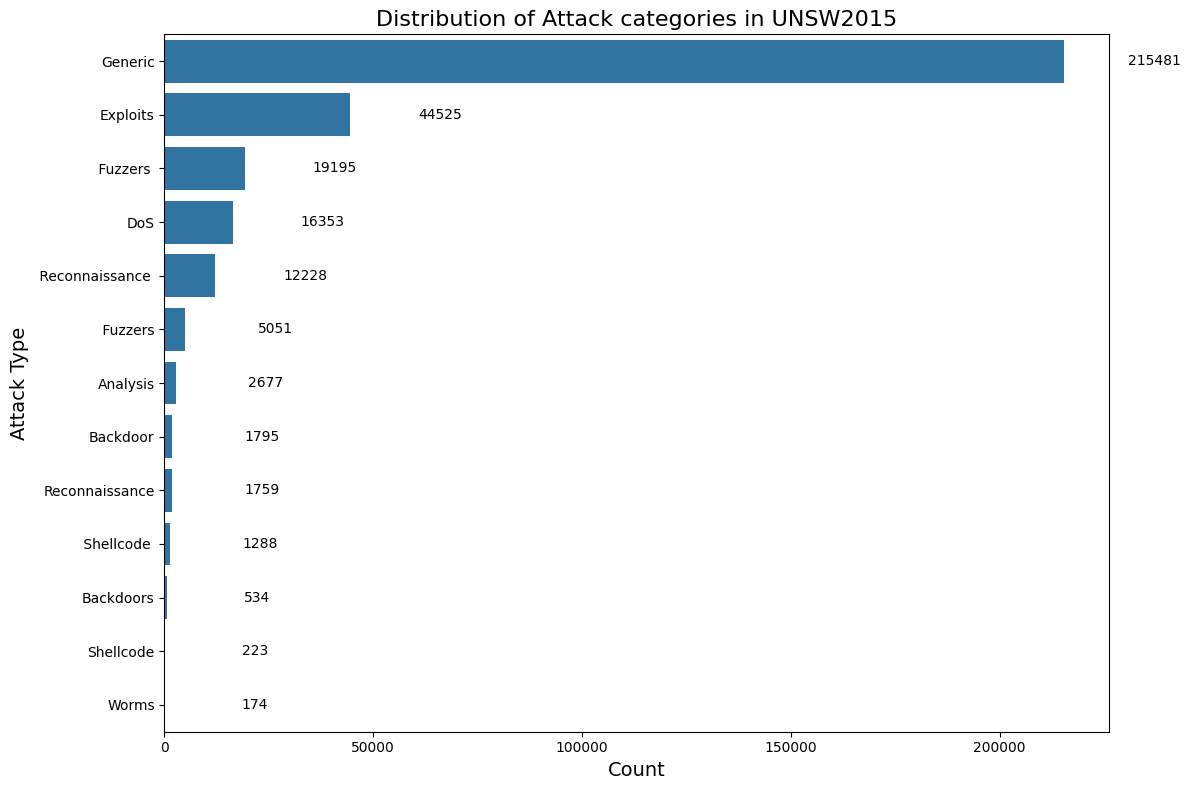

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

target_col = 'attack_cat'
plt.figure(figsize=(12, 8))
ax = sns.countplot(df_unsw, y=target_col, order=df_unsw[target_col].value_counts().index)

# 3. Add annotations and styling
plt.title('Distribution of Attack categories in UNSW2015', fontsize=16)
plt.xlabel('Count', fontsize=14)
plt.ylabel('Attack Type', fontsize=14)

# Add count values on each bar
for p in ax.patches:
    width = p.get_width()
    plt.text(width + 0.1 * max(df_unsw[target_col].value_counts()),
             p.get_y() + p.get_height()/2.,
             f'{int(width)}',
             ha='center', va='center')

plt.tight_layout()
plt.show()

In [ ]:
# 1.1 Fix odd column names (spaces, case)
df = df.rename(columns=lambda c: c.strip().replace(" ", "_"))
# e.g., 'ct_src_ ltm' -> 'ct_src__ltm' above; normalize further:
df = df.rename(columns={"ct_src__ltm": "ct_src_ltm"})

# 1.2 Coerce ports to numeric (often object in raw CSVs)
for col in ["sport", "dsport", "ct_ftp_cmd"]:
    if col in df.columns and df[col].dtype == "object":
        df[col] = pd.to_numeric(df[col], errors="coerce")

# 1.3 Convert low-cardinality text to category (saves RAM; fine for OneHot later)
for col in ["proto", "state", "service", "srcip", "dstip", "attack_cat"]:
    if col in df.columns and df[col].dtype == "object":
        # IPs are high-card; still set to category for cheaper memory even if we later drop them
        df[col] = df[col].astype("category")

# 1.4 Downcast numerics where safe
def downcast_df(dfx):
    for c in dfx.select_dtypes(include=["int64"]).columns:
        dfx[c] = pd.to_numeric(dfx[c], downcast="unsigned")  # counts/IDs are nonnegative in UNSW
    for c in dfx.select_dtypes(include=["float64"]).columns:
        dfx[c] = pd.to_numeric(dfx[c], downcast="float")
    return dfx

df = downcast_df(df)
print(df.dtypes.value_counts())
print("RAM (MB):", df.memory_usage(deep=True).sum()/1024**2)


uint8       15
float32     11
uint32       7
uint16       6
float64      4
category     1
category     1
category     1
category     1
category     1
category     1
Name: count, dtype: int64
RAM (MB): 334.309627532959


In [ ]:
# 2.1 Normalize labels
assert "Label" in df.columns and "attack_cat" in df.columns, "Expected Label & attack_cat columns."
df["Attack"] = df["Label"].astype("int8")  # 1=attack, 0=normal

# 2.2 Pick UNSEEN zero-day categories (least frequent TWO, reproducibly)
atk_only = df[df["Attack"]==1]
vc = atk_only["attack_cat"].value_counts()
# Keep only valid strings
vc = vc[vc.index.notna()]
unseen_cats = list(vc.sort_values(ascending=True).head(2).index)  # e.g., ['Worms','Shellcode'] usually
print("Zero-day UNSEEN categories:", unseen_cats)

is_unseen = df["attack_cat"].isin(unseen_cats)
df_seen   = df[(~is_unseen) | (df["Attack"]==0)].copy()   # all benign + seen attacks
df_unseen = df[( is_unseen) | (df["Attack"]==0)].copy()   # all benign + unseen attacks

print("SEEN:", df_seen.shape, "UNSEEN:", df_unseen.shape)


Zero-day UNSEEN categories: ['Worms', 'Shellcode']
SEEN: (2539646, 50) UNSEEN: (2219157, 50)


In [ ]:
from sklearn.model_selection import train_test_split

# 3.1 Train on benign-only from SEEN
train_benign = df_seen[df_seen["Attack"]==0].copy()

# 3.2 Validation (SEEN): stratified sample for stable thresholding
val_frac = 0.30
val_df, _ = train_test_split(
    df_seen, test_size=(1 - val_frac),
    stratify=df_seen["Attack"], random_state=42
)

# 3.3 Test sets from UNSEEN
test_df = df_unseen.copy()

# REALISTIC prevalence (e.g., 10% attacks)
target_prev = 0.10
ben = test_df[test_df["Attack"]==0]
atk = test_df[test_df["Attack"]==1]
n_b = len(ben)
n_a = min(len(atk), int(n_b * target_prev / (1 - target_prev)))
atk_down = atk.sample(n=n_a, random_state=42) if n_a>0 else atk
test_realistic = pd.concat([ben, atk_down]).sample(frac=1.0, random_state=42).reset_index(drop=True)

# STRESS: as-is
test_stress = test_df.sample(frac=1.0, random_state=42).reset_index(drop=True)

for nm, d in [("train_benign", train_benign), ("val_df", val_df),
              ("test_realistic", test_realistic), ("test_stress", test_stress)]:
    print(nm, d.shape, "attack ratio:", d["Attack"].mean())

# Save splits
split_dir = f"{BASE}/splits"
train_benign.to_parquet(f"{split_dir}/train_benign_seen.parquet", index=False)
val_df.to_parquet(        f"{split_dir}/val_seen.parquet",        index=False)
test_realistic.to_parquet(f"{split_dir}/test_unseen_realistic.parquet", index=False)
test_stress.to_parquet(   f"{split_dir}/test_unseen_stress.parquet",    index=False)
with open(f"{split_dir}/meta.json","w") as f:
    json.dump({"unseen_categories": [str(x) for x in unseen_cats],
               "target_attack_prevalence_realistic": target_prev}, f, indent=2)


train_benign (2218760, 50) attack ratio: 0.0
val_df (761893, 50) attack ratio: 0.1263510755447287
test_realistic (2219157, 50) attack ratio: 0.00017889676124762692
test_stress (2219157, 50) attack ratio: 0.00017889676124762692


In [ ]:
drop_cols = [c for c in ["srcip","dstip","Stime","Ltime","stcpb","dtcpb"] if c in df.columns]
cat_cols  = [c for c in ["proto","state","service"] if c in df.columns]
label_cols = ["Label","attack_cat","Attack"]

# numeric candidates = all numeric minus drops & labels
num_cols = df.select_dtypes(include=["float32","float64","int16","int32","int64","uint8","uint16","uint32"]).columns.tolist()
num_cols = [c for c in num_cols if c not in set(drop_cols + label_cols)]

# remove ports if you choose not to use them
# num_cols = [c for c in num_cols if c not in ("sport","dsport")]

print("Drop cols:", drop_cols)
print("Categoricals:", cat_cols)
print("Numeric count:", len(num_cols))


Drop cols: ['srcip', 'dstip', 'Stime', 'Ltime', 'stcpb', 'dtcpb']
Categoricals: ['proto', 'state', 'service']
Numeric count: 38


In [ ]:
import numpy as np, pandas as pd, gc

# Categoricals to keep (if present)
cat_cols  = [c for c in ["proto","state","service"] if c in train_benign.columns]
label_cols = ["Label","attack_cat","Attack"]

# Build code maps on TRAIN BENIGN ONLY (no leakage)
code_maps = {}
for c in cat_cols:
    cats = pd.Categorical(train_benign[c]).categories.tolist()
    code_maps[c] = {v:i for i,v in enumerate(cats)}

# FIXED encoder: map from object, allow -1 for unseen categories
def add_codes(df_in):
    df_out = df_in  # in-place to save RAM
    for c in cat_cols:
        cmap = code_maps[c]
        df_out[c + "_code"] = df_out[c].astype("object").map(cmap).fillna(-1).astype("int16")
    return df_out

# Apply to all splits
train_benign = add_codes(train_benign)
val_df       = add_codes(val_df)
test_realistic = add_codes(test_realistic)
test_stress    = add_codes(test_stress)

code_cols = [c+"_code" for c in cat_cols]

# Drop high-card/ID/leakage columns if present
drop_cols = [c for c in ["srcip","dstip","Stime","Ltime","stcpb","dtcpb"] if c in train_benign.columns]
for df_ in (train_benign, val_df, test_realistic, test_stress):
    for c in drop_cols:
        if c in df_.columns: df_.drop(columns=c, inplace=True)

# Numeric base features (we add code_cols later)
num_base_cols = train_benign.select_dtypes(include=[np.number]).columns.tolist()
num_base_cols = [c for c in num_base_cols if c not in set(label_cols + code_cols)]
print("num_base_cols:", len(num_base_cols), " | code_cols:", code_cols)
gc.collect();


num_base_cols: 38  | code_cols: ['proto_code', 'state_code', 'service_code']


In [ ]:
def compute_clip_bounds(df_num, lower=1.0, upper=99.0):
    lo = df_num.quantile(lower/100.0)
    hi = df_num.quantile(upper/100.0)
    return lo.to_dict(), hi.to_dict()

train_benign_num = train_benign[num_base_cols].astype("float32", copy=False)
lo_b, hi_b = compute_clip_bounds(train_benign_num, 1.0, 99.0)
del train_benign_num; gc.collect()

def clip_numeric_block(df_in):
    Xn = df_in[num_base_cols].astype("float32", copy=True)
    for c in num_base_cols:
        Xn[c] = np.clip(Xn[c].values, lo_b[c], hi_b[c])
    return Xn

def build_matrix(df_in):
    # numeric (winsorized) + categorical codes (as float32)
    Xn = clip_numeric_block(df_in)
    Xc = df_in[code_cols].astype("float32", copy=False) if code_cols else None
    return Xn if Xc is None else pd.concat([Xn, Xc], axis=1)


In [ ]:
from sklearn.preprocessing import RobustScaler, StandardScaler

# Sample benign for fitting scaler (keeps RAM/time low)
N_TRAIN_MAX = 400_000
rs = np.random.RandomState(42)
idx_fit = rs.choice(len(train_benign), size=min(N_TRAIN_MAX, len(train_benign)), replace=False)
train_sample = train_benign.iloc[idx_fit]

Scaler = RobustScaler  # robust to heavy tails
scaler = Scaler(with_centering=True, with_scaling=True)

X_train_sample_df = build_matrix(train_sample)
scaler.fit(X_train_sample_df.values)
del X_train_sample_df, train_sample; gc.collect()

def transform_split(df_in):
    Xdf = build_matrix(df_in)
    X = scaler.transform(Xdf.values).astype("float32", copy=False)
    del Xdf; gc.collect()
    return X

X_train = transform_split(train_benign)     # benign-only (you can subsample for fit below)
X_val   = transform_split(val_df)
X_tr    = transform_split(test_realistic)
X_ts    = transform_split(test_stress)

y_val = val_df["Attack"].astype(int).values
y_tr  = test_realistic["Attack"].astype(int).values
y_ts  = test_stress["Attack"].astype(int).values

print("Shapes -> X_train:", X_train.shape, "  X_val:", X_val.shape, "  X_tr:", X_tr.shape, "  X_ts:", X_ts.shape)
gc.collect();


Shapes -> X_train: (2218760, 41)   X_val: (761893, 41)   X_tr: (2219157, 41)   X_ts: (2219157, 41)


In [ ]:
N_FIT_MAX = 400_000
if len(X_train) > N_FIT_MAX:
    idx_fit2 = rs.choice(len(X_train), size=N_FIT_MAX, replace=False)
    X_fit = X_train[idx_fit2]
else:
    X_fit = X_train
print("Fitting on:", X_fit.shape)


Fitting on: (400000, 41)


In [ ]:
from sklearn.metrics import precision_recall_curve, classification_report, roc_auc_score, confusion_matrix, roc_curve, precision_recall_fscore_support
import numpy as np

def pick_thresh_by_Fbeta(y_true, scores, beta=2.0):
    P, R, thr = precision_recall_curve(y_true, scores)
    P, R = P[:-1], R[:-1]
    fbeta = (1+beta**2) * (P*R) / (beta**2 * P + R + 1e-12)
    i = np.nanargmax(fbeta)
    return float(thr[i]), float(P[i]), float(R[i]), float(fbeta[i])

def pick_thresh_at_fpr(y_true, scores, max_fpr=0.05):
    fpr, tpr, thr = roc_curve(y_true, scores)
    ok = np.where(fpr <= max_fpr)[0]
    if len(ok)==0:
        j = np.argmax(tpr - fpr)
        return float(thr[j]), float(fpr[j]), float(tpr[j])
    i = ok[np.argmax(tpr[ok])]
    return float(thr[i]), float(fpr[i]), float(tpr[i])

def summarize(y_true, y_pred, scores, name=""):
    P,R,F1,_ = precision_recall_fscore_support(y_true, y_pred, average='binary', zero_division=0)
    auc_ = roc_auc_score(y_true, scores) if len(np.unique(y_true))>1 else np.nan
    cm = confusion_matrix(y_true, y_pred)
    print(f"\n== {name} ==")
    print(f"Precision={P:.4f}  Recall={R:.4f}  F1={F1:.4f}  ROC-AUC={auc_:.4f}")
    print("Confusion matrix:\n", cm)
    print(classification_report(y_true, y_pred, digits=4))


# Train and Evaluate Isolation Forest

In [ ]:
from sklearn.ensemble import IsolationForest

iforest = IsolationForest(
    n_estimators=400, max_samples='auto', contamination='auto',
    random_state=42, n_jobs=-1
).fit(X_fit)

val_scores = -iforest.score_samples(X_val)
tr_scores  = -iforest.score_samples(X_tr)
ts_scores  = -iforest.score_samples(X_ts)

# F2-optimal threshold (recall-oriented)
th_f2, p_f2, r_f2, f2 = pick_thresh_by_Fbeta(y_val, val_scores, beta=2.0)
y_tr_f2 = (tr_scores >= th_f2).astype(int)
y_ts_f2 = (ts_scores >= th_f2).astype(int)
print(f"IForest F2 threshold: {th_f2:.6f} (val P={p_f2:.3f}, R={r_f2:.3f}, F2={f2:.3f})")
summarize(y_tr, y_tr_f2, tr_scores, "IForest | REALISTIC | F2-opt")
summarize(y_ts, y_ts_f2, ts_scores, "IForest | STRESS    | F2-opt")

# FPR-controlled threshold (≤5% on validation)
th_fpr, fpr_sel, tpr_sel = pick_thresh_at_fpr(y_val, val_scores, max_fpr=0.05)
y_tr_fpr = (tr_scores >= th_fpr).astype(int)
y_ts_fpr = (ts_scores >= th_fpr).astype(int)
print(f"IForest FPR<=5% threshold: {th_fpr:.6f} (val FPR={fpr_sel:.3f}, TPR={tpr_sel:.3f})")
summarize(y_tr, y_tr_fpr, tr_scores, "IForest | REALISTIC | FPR<=5%")
summarize(y_ts, y_ts_fpr, ts_scores, "IForest | STRESS    | FPR<=5%")


IForest F2 threshold: 0.505144 (val P=0.578, R=0.993, F2=0.868)

== IForest | REALISTIC | F2-opt ==
Precision=0.0017  Recall=0.9975  F1=0.0034  ROC-AUC=0.9615
Confusion matrix:
 [[1986445  232315]
 [      1     396]]
              precision    recall  f1-score   support

           0     1.0000    0.8953    0.9448   2218760
           1     0.0017    0.9975    0.0034       397

    accuracy                         0.8953   2219157
   macro avg     0.5009    0.9464    0.4741   2219157
weighted avg     0.9998    0.8953    0.9446   2219157


== IForest | STRESS    | F2-opt ==
Precision=0.0017  Recall=0.9975  F1=0.0034  ROC-AUC=0.9615
Confusion matrix:
 [[1986445  232315]
 [      1     396]]
              precision    recall  f1-score   support

           0     1.0000    0.8953    0.9448   2218760
           1     0.0017    0.9975    0.0034       397

    accuracy                         0.8953   2219157
   macro avg     0.5009    0.9464    0.4741   2219157
weighted avg     0.9998    0.89

In [ ]:
import numpy as np

def check_finiteness(X, name):
    n = X.shape[0]
    bad_nan = np.isnan(X).sum()
    bad_inf = np.isinf(X).sum()
    print(f"{name}: NaN={bad_nan}, Inf={bad_inf}, shape={X.shape}")

check_finiteness(X_train, "X_train")
check_finiteness(X_val,   "X_val")
check_finiteness(X_tr,    "X_tr")
check_finiteness(X_ts,    "X_ts")


X_train: NaN=3330904, Inf=0, shape=(2218760, 41)
X_val: NaN=1263517, Inf=0, shape=(761893, 41)
X_tr: NaN=3331234, Inf=0, shape=(2219157, 41)
X_ts: NaN=3331234, Inf=0, shape=(2219157, 41)


In [ ]:
import numpy as np, pandas as pd, gc
from sklearn.preprocessing import RobustScaler

# 1) Identify the columns we intend to use
label_cols = ["Label","attack_cat","Attack"]
code_cols  = [c for c in ["proto_code","state_code","service_code"] if c in train_benign.columns]

# Base numeric candidates = all numeric except labels & codes
num_base_cols = train_benign.select_dtypes(include=[np.number]).columns.tolist()
num_base_cols = [c for c in num_base_cols if c not in set(label_cols + code_cols)]

# 2) Drop columns that are ALL-NaN in train_benign
all_nan_cols = train_benign[num_base_cols].isna().all(axis=0)
drop_all_nan = all_nan_cols[all_nan_cols].index.tolist()
if drop_all_nan:
    print("Dropping all-NaN numeric cols:", drop_all_nan)
num_base_cols = [c for c in num_base_cols if c not in set(drop_all_nan)]

# 3) Compute clip bounds (1st/99th) on train_benign and FIX any NaN bounds by using the median
def compute_clip_bounds_safe(df_num, lower=1.0, upper=99.0):
    lo = df_num.quantile(lower/100.0)
    hi = df_num.quantile(upper/100.0)
    med = df_num.median()
    # Replace NaN lo/hi with median; if still NaN, use 0.0
    lo = lo.fillna(med).fillna(0.0)
    hi = hi.fillna(med).fillna(0.0)
    # Ensure lo <= hi
    bad = lo > hi
    if bad.any():
        # when inverted, set both to median
        lo[bad] = med[bad]
        hi[bad] = med[bad]
    return lo.to_dict(), hi.to_dict()

train_benign_num = train_benign[num_base_cols].astype("float32", copy=False)
lo_b, hi_b = compute_clip_bounds_safe(train_benign_num, 1.0, 99.0)
del train_benign_num; gc.collect()

# 4) Clip numerics and build matrices (numeric + code cols)
def clip_numeric_block(df_in, cols, lo_b, hi_b):
    Xn = df_in[cols].astype("float32", copy=True)
    for c in cols:
        lo, hi = lo_b[c], hi_b[c]
        # safe clip; if lo==hi, this becomes a constant column (we'll drop constants next)
        Xn[c] = np.clip(Xn[c].values, lo, hi)
    return Xn

def build_matrix(df_in):
    Xn = clip_numeric_block(df_in, num_base_cols, lo_b, hi_b)
    Xc = df_in[code_cols].astype("float32", copy=False) if code_cols else None
    X = Xn if Xc is None else pd.concat([Xn, Xc], axis=1)
    return X

X_train_df = build_matrix(train_benign)
X_val_df   = build_matrix(val_df)
X_tr_df    = build_matrix(test_realistic)
X_ts_df    = build_matrix(test_stress)

# 5) Drop constant columns (zero variance on TRAIN)
stds = X_train_df.std(axis=0, ddof=0)
const_cols = stds[~np.isfinite(stds) | (stds == 0)].index.tolist()
if const_cols:
    print("Dropping constant/invalid cols:", const_cols)
    X_train_df.drop(columns=const_cols, inplace=True, errors="ignore")
    X_val_df.drop(columns=const_cols, inplace=True, errors="ignore")
    X_tr_df.drop(columns=const_cols, inplace=True, errors="ignore")
    X_ts_df.drop(columns=const_cols, inplace=True, errors="ignore")

# 6) Scale with RobustScaler on benign sample
from sklearn.preprocessing import RobustScaler
rs = np.random.RandomState(42)
N_TRAIN_MAX = 400_000
idx_fit = rs.choice(len(X_train_df), size=min(N_TRAIN_MAX, len(X_train_df)), replace=False)
scaler = RobustScaler(with_centering=True, with_scaling=True)
scaler.fit(X_train_df.iloc[idx_fit].values)

def transform_df_to_array(Xdf):
    X = scaler.transform(Xdf.values).astype("float32", copy=False)
    # enforce finiteness just in case
    X = np.nan_to_num(X, nan=0.0, posinf=1e6, neginf=-1e6)
    return X

X_train = transform_df_to_array(X_train_df); del X_train_df
X_val   = transform_df_to_array(X_val_df);   del X_val_df
X_tr    = transform_df_to_array(X_tr_df);    del X_tr_df
X_ts    = transform_df_to_array(X_ts_df);    del X_ts_df
gc.collect()

# 7) Re-check finiteness
def check_finiteness(X, name):
    print(name, "NaN:", np.isnan(X).sum(), "Inf:", np.isinf(X).sum(), "shape:", X.shape)
check_finiteness(X_train, "X_train")
check_finiteness(X_val,   "X_val")
check_finiteness(X_tr,    "X_tr")
check_finiteness(X_ts,    "X_ts")

# 8) If you want to train on a subset of X_train (benign), pick it now
N_FIT_MAX = 400_000
if len(X_train) > N_FIT_MAX:
    idx_fit2 = rs.choice(len(X_train), size=N_FIT_MAX, replace=False)
    X_fit = X_train[idx_fit2]
else:
    X_fit = X_train
print("Fitting AE on:", X_fit.shape)


Dropping constant/invalid cols: ['is_sm_ips_ports']
X_train NaN: 0 Inf: 0 shape: (2218760, 40)
X_val NaN: 0 Inf: 0 shape: (761893, 40)
X_tr NaN: 0 Inf: 0 shape: (2219157, 40)
X_ts NaN: 0 Inf: 0 shape: (2219157, 40)
Fitting AE on: (400000, 40)


# Train and Evaluate Autoencoder

In [ ]:
import tensorflow as tf
from tensorflow import keras
tf.random.set_seed(42)

input_dim = X_fit.shape[1]
inp = keras.Input(shape=(input_dim,))
x = keras.layers.Dense(256, activation='relu')(inp)
x = keras.layers.Dense(128, activation='relu')(x)
z = keras.layers.Dense(64,  activation='relu')(x)
x = keras.layers.Dense(128, activation='relu')(z)
x = keras.layers.Dense(256, activation='relu')(x)
out = keras.layers.Dense(input_dim, activation='linear')(x)

ae = keras.Model(inp, out)
ae.compile(optimizer=keras.optimizers.Adam(learning_rate=5e-4, clipnorm=1.0), loss='mse')
es = keras.callbacks.EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)
_ = ae.fit(X_fit, X_fit, epochs=60, batch_size=1024, shuffle=True, callbacks=[es], verbose=0)

# Reconstructions
val_rec = ae.predict(X_val, batch_size=4096, verbose=0)
tr_rec  = ae.predict(X_tr,  batch_size=4096, verbose=0)
ts_rec  = ae.predict(X_ts,  batch_size=4096, verbose=0)

# Errors (now guaranteed finite)
val_err = np.mean((X_val - val_rec)**2, axis=1).astype("float32")
tr_err  = np.mean((X_tr  - tr_rec )**2, axis=1).astype("float32")
ts_err  = np.mean((X_ts  - ts_rec )**2, axis=1).astype("float32")

# Threshold selection & evaluation (same functions you already have)
th_f2_ae, p_f2_ae, r_f2_ae, f2_ae = pick_thresh_by_Fbeta(y_val, val_err, beta=2.0)
y_tr_f2_ae = (tr_err >= th_f2_ae).astype(int)
y_ts_f2_ae = (ts_err >= th_f2_ae).astype(int)
print(f"AE F2 threshold: {th_f2_ae:.6f} (val P={p_f2_ae:.3f}, R={r_f2_ae:.3f}, F2={f2_ae:.3f})")
summarize(y_tr, y_tr_f2_ae, tr_err, "AE | REALISTIC | F2-opt")
summarize(y_ts, y_ts_f2_ae, ts_err, "AE | STRESS    | F2-opt")

th_fpr_ae, fpr_sel_ae, tpr_sel_ae = pick_thresh_at_fpr(y_val, val_err, max_fpr=0.05)
y_tr_fpr_ae = (tr_err >= th_fpr_ae).astype(int)
y_ts_fpr_ae = (ts_err >= th_fpr_ae).astype(int)
print(f"AE FPR<=5% threshold: {th_fpr_ae:.6f} (val FPR={fpr_sel_ae:.3f}, TPR={tpr_sel_ae:.3f})")
summarize(y_tr, y_tr_fpr_ae, tr_err, "AE | REALISTIC | FPR<=5%")
summarize(y_ts, y_ts_fpr_ae, ts_err, "AE | STRESS    | FPR<=5%")


AE F2 threshold: 0.109362 (val P=0.558, R=0.998, F2=0.862)

== AE | REALISTIC | F2-opt ==
Precision=0.0016  Recall=1.0000  F1=0.0031  ROC-AUC=0.9281
Confusion matrix:
 [[1965200  253560]
 [      0     397]]
              precision    recall  f1-score   support

           0     1.0000    0.8857    0.9394   2218760
           1     0.0016    1.0000    0.0031       397

    accuracy                         0.8857   2219157
   macro avg     0.5008    0.9429    0.4713   2219157
weighted avg     0.9998    0.8857    0.9392   2219157


== AE | STRESS    | F2-opt ==
Precision=0.0016  Recall=1.0000  F1=0.0031  ROC-AUC=0.9281
Confusion matrix:
 [[1965200  253560]
 [      0     397]]
              precision    recall  f1-score   support

           0     1.0000    0.8857    0.9394   2218760
           1     0.0016    1.0000    0.0031       397

    accuracy                         0.8857   2219157
   macro avg     0.5008    0.9429    0.4713   2219157
weighted avg     0.9998    0.8857    0.9392   

In [ ]:
import joblib, json, os
BASE = "/content/drive/MyDrive/colab_zero_day_unsw"
os.makedirs(f"{BASE}/models", exist_ok=True)

joblib.dump(scaler,   f"{BASE}/models/scaler.joblib")
joblib.dump(iforest,  f"{BASE}/models/iforest.joblib")
ae.save(f"{BASE}/models/autoencoder_ae.keras")

with open(f"{BASE}/models/columns.json","w") as f:
    json.dump({"num_base_cols": num_base_cols, "code_cols": code_cols}, f, indent=2)

with open(f"{BASE}/models/thresholds.json","w") as f:
    json.dump({
        "iforest": {"F2": float(th_f2), "FPR5": float(th_fpr)},
        "autoencoder": {"F2": float(th_f2_ae), "FPR5": float(th_fpr_ae)}
    }, f, indent=2)
print("Saved models + thresholds.")


Saved models + thresholds.
